### Классификация: превышает ли значение SI медианное значение выборки

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
df_scaled.shape

(969, 188)

In [4]:
df_scaled.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


### Сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import optuna

# Загрузка данных
# df_scaled = pd.read_csv('df_scaled.csv')

# df_scaled - DataFrame, содержащий данные, в том числе 'SI'
y = (df_scaled['SI'] > df_scaled['SI'].median()).astype(int)  # Бинарная целевая переменная
X = df_scaled.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42 ,stratify=y)

# Словарь классификаторов для оптимизации
CLASSIFIERS = {
    'XGBClassifier': XGBClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'CatBoostClassifier': CatBoostClassifier
}

# Функция для объектов обработки с использованием Optuna
def objective(trial, classifier_name):
    # Определяем параметры для каждого классификатора
    params = {}
    
    if classifier_name == 'XGBClassifier':
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBClassifier(**params)
    
    elif classifier_name == 'DecisionTreeClassifier':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeClassifier(**params)

    elif classifier_name == 'RandomForestClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == 'CatBoostClassifier':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  # Отключаем вывод информации о процессе обучения
        }
        model = CatBoostClassifier(**params)

    # Обучение модели
    model.fit(X_train, y_train)

    # Прогнозирование на тестовой выборке
    y_pred = model.predict(X_test)

    # Оценка модели
    f1 = f1_score(y_test, y_pred)
    return f1  # Возвращаем F1-score для оптимизации

# Оптимизация гиперпараметров для каждого классификатора
best_models = {}
for classifier_name in CLASSIFIERS.keys():
    print(f"Оптимизация гиперпараметров для {classifier_name}...")
    study = optuna.create_study(direction='maximize')  # Максимизируем F1-score
    study.optimize(lambda trial: objective(trial, classifier_name), n_trials=250)  # Число итераций оптимизации

    # Сохранение наилучших параметров и модели
    best_models[classifier_name] = {
        'best_params': study.best_params,
        'best_model': CLASSIFIERS[classifier_name](**study.best_params).fit(X_train, y_train)
    }

    print(f"Оптимальные гиперпараметры для {classifier_name}:", study.best_params)

# Оценка всех моделей на тестовой выборке
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"{classifier_name} - Тестовая точность: {accuracy}, Тестовый F1-score: {f1}")

[I 2025-05-24 13:14:24,356] A new study created in memory with name: no-name-792c7c73-3f20-4b0a-8b42-d2e068f31c0f


Оптимизация гиперпараметров для XGBClassifier...


[I 2025-05-24 13:14:25,913] Trial 0 finished with value: 0.5853658536585366 and parameters: {'learning_rate': 0.0003520087732789001, 'max_depth': 8, 'n_estimators': 494, 'subsample': 0.5512969147758571, 'colsample_bytree': 0.5972954357588391}. Best is trial 0 with value: 0.5853658536585366.
[I 2025-05-24 13:14:26,154] Trial 1 finished with value: 0.6187050359712231 and parameters: {'learning_rate': 0.04350695079553696, 'max_depth': 3, 'n_estimators': 197, 'subsample': 0.7081445913790525, 'colsample_bytree': 0.9679750168862453}. Best is trial 1 with value: 0.6187050359712231.
[I 2025-05-24 13:14:26,326] Trial 2 finished with value: 0.6527777777777778 and parameters: {'learning_rate': 0.22132806712457698, 'max_depth': 8, 'n_estimators': 55, 'subsample': 0.574987546945527, 'colsample_bytree': 0.6907518935501513}. Best is trial 2 with value: 0.6527777777777778.
[I 2025-05-24 13:14:26,705] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 0.00023674177977186516, 'max_depth'

Оптимальные гиперпараметры для XGBClassifier: {'learning_rate': 0.01572526139195517, 'max_depth': 8, 'n_estimators': 343, 'subsample': 0.9656686239798765, 'colsample_bytree': 0.971379249029169}
Оптимизация гиперпараметров для DecisionTreeClassifier...


[I 2025-05-24 13:17:44,347] Trial 4 finished with value: 0.6148148148148148 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.625.
[I 2025-05-24 13:17:44,385] Trial 5 finished with value: 0.5813148788927336 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.625.
[I 2025-05-24 13:17:44,406] Trial 6 finished with value: 0.6116838487972509 and parameters: {'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.625.
[I 2025-05-24 13:17:44,423] Trial 7 finished with value: 0.6007067137809188 and parameters: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.625.
[I 2025-05-24 13:17:44,466] Trial 8 finished with value: 0.5878136200716846 and parameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.625.
[I 2025-05-24 13:17:44,489] Trial 

Оптимальные гиперпараметры для DecisionTreeClassifier: {'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 8}
Оптимизация гиперпараметров для RandomForestClassifier...


[I 2025-05-24 13:17:53,212] Trial 0 finished with value: 0.6053639846743295 and parameters: {'n_estimators': 245, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6053639846743295.
[I 2025-05-24 13:17:53,939] Trial 1 finished with value: 0.6053639846743295 and parameters: {'n_estimators': 403, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6053639846743295.
[I 2025-05-24 13:17:54,575] Trial 2 finished with value: 0.609375 and parameters: {'n_estimators': 417, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.609375.
[I 2025-05-24 13:17:54,905] Trial 3 finished with value: 0.5419847328244275 and parameters: {'n_estimators': 397, 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.609375.
[I 2025-05-24 13:17:55,717] Trial 4 finished with value: 0.6287878787878788 and parameters: {'n_estimators': 474, 'max_dept

Оптимальные гиперпараметры для RandomForestClassifier: {'n_estimators': 63, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3}
Оптимизация гиперпараметров для CatBoostClassifier...


[I 2025-05-24 13:20:13,530] Trial 0 finished with value: 0.6236559139784946 and parameters: {'learning_rate': 0.008070837031705375, 'depth': 10, 'iterations': 203, 'l2_leaf_reg': 0.004445420167017128}. Best is trial 0 with value: 0.6236559139784946.
[I 2025-05-24 13:20:16,812] Trial 1 finished with value: 0.6074074074074074 and parameters: {'learning_rate': 0.0006193534178219891, 'depth': 8, 'iterations': 158, 'l2_leaf_reg': 0.031081740603693765}. Best is trial 0 with value: 0.6236559139784946.
[I 2025-05-24 13:20:17,240] Trial 2 finished with value: 0.5625 and parameters: {'learning_rate': 0.00027801331329408953, 'depth': 4, 'iterations': 172, 'l2_leaf_reg': 0.28354234668665274}. Best is trial 0 with value: 0.6236559139784946.
[I 2025-05-24 13:20:17,582] Trial 3 finished with value: 0.5874125874125874 and parameters: {'learning_rate': 0.24784607145973067, 'depth': 2, 'iterations': 212, 'l2_leaf_reg': 0.0007665108960186016}. Best is trial 0 with value: 0.6236559139784946.
[I 2025-05-24

0:	learn: 0.6774707	total: 927us	remaining: 244ms
1:	learn: 0.6685735	total: 1.89ms	remaining: 247ms
2:	learn: 0.6660666	total: 2.68ms	remaining: 233ms
3:	learn: 0.6646782	total: 3.53ms	remaining: 230ms
4:	learn: 0.6598774	total: 4.22ms	remaining: 219ms
5:	learn: 0.6556825	total: 4.98ms	remaining: 214ms
6:	learn: 0.6513017	total: 5.75ms	remaining: 211ms
7:	learn: 0.6478678	total: 6.53ms	remaining: 209ms
8:	learn: 0.6438098	total: 7.23ms	remaining: 205ms
9:	learn: 0.6420069	total: 7.95ms	remaining: 202ms
10:	learn: 0.6399167	total: 8.87ms	remaining: 204ms
11:	learn: 0.6362926	total: 9.79ms	remaining: 206ms
12:	learn: 0.6308976	total: 10.8ms	remaining: 209ms
13:	learn: 0.6288945	total: 11.7ms	remaining: 208ms
14:	learn: 0.6260572	total: 12.6ms	remaining: 209ms
15:	learn: 0.6241369	total: 13.5ms	remaining: 210ms
16:	learn: 0.6216612	total: 14.3ms	remaining: 208ms
17:	learn: 0.6202830	total: 15ms	remaining: 205ms
18:	learn: 0.6176561	total: 15.8ms	remaining: 203ms
19:	learn: 0.6152971	tota

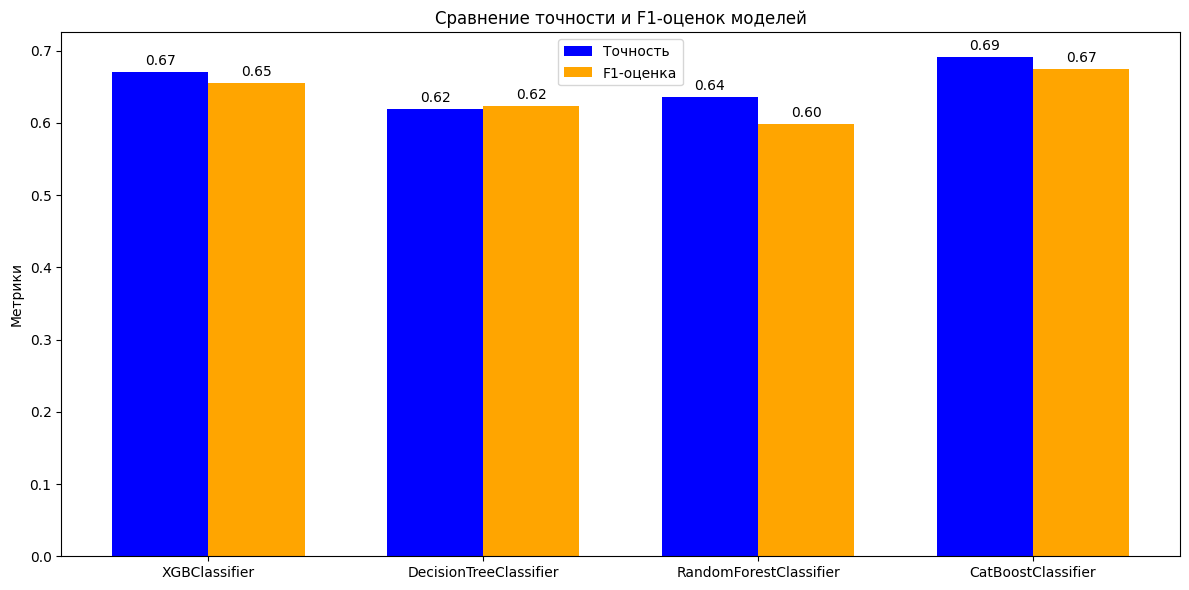

In [6]:
# Визуализация результатов
import matplotlib.pyplot as plt

# Сбор данных для визуализации
models_names = list(best_models.keys())
accuracies = []
f1_scores = []

# Заполнение массивов оценками каждой модели
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    accuracies.append(accuracy)
    f1_scores.append(f1)

# Визуализация результатов
x = np.arange(len(models_names))  # метки для оси x
width = 0.35  # ширина столбцов

fig, ax = plt.subplots(figsize=(12, 6))

# Построение столбчатых диаграмм для точности и F1-оценок
bars1 = ax.bar(x - width/2, accuracies, width, label='Точность', color='blue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-оценка', color='orange')

# Настройка отметок оси x и заголовка
ax.set_ylabel('Метрики')
ax.set_title('Сравнение точности и F1-оценок моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()

# Добавление значений над столбцами
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # Отодвигаем значение немного вверх
                    textcoords="offset points", 
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Отображение графика
plt.tight_layout()
plt.show()

*На основе представленных метрик тестовой точности и F1-score для различных классификаторов, можно сделать следующие выводы:*

*Сравнение моделей*
- *XGBClassifier:*
- Тестовая точность: 0.6701
- Тестовый F1-score: 0.6547
- Данная модель показывает хорошие результаты, однако не является лучшей из представленных.
- *DecisionTreeClassifier:*
- Тестовая точность: 0.6186
- Тестовый F1-score: 0.6237
- Показатели этой модели являются наименьшими среди всех классификаторов, что свидетельствует о её менее эффективной работе по сравнению с другими.
- *RandomForestClassifier:*
- Тестовая точность: 0.6357
- Тестовый F1-score: 0.5985
- Хотя Random Forest использует ансамблевый подход, его результаты также не впечатляют и находятся между Decision Tree и XGBClassifier.
- *CatBoostClassifier:*
- Тестовая точность: 0.6907
- Тестовый F1-score: 0.6739
- Эта модель показывает наилучшие результаты в обеих метриках, что делает её наиболее предпочтительной среди представленных.
- *Общие выводы*
- Лучшие результаты демонстрирует CatBoostClassifier, с высокой точностью и F1-score.
- XGBClassifier занимает второе место, также демонстрируя приличные показатели, но не дотягивает до CatBoost.
- DecisionTreeClassifier и RandomForestClassifier показывают худшие результаты, с заметным отставанием от первой пары моделей.
*Рекомендации*
- Рекомендуется использовать CatBoostClassifier для задач, где важны высокая точность и сбалансированность классификации.
Возможно, стоит провести дополнительную настройку гиперпараметров для XGBClassifier, чтобы улучшить его показатели.
Следует учитывать, что различия в метриках могут зависеть от особенностей данных, поэтому желательно провести дополнительные испытания и валидацию.

*Данный код демонстрирует процесс сохранения и загрузки обученных моделей машинного обучения с использованием библиотеки `pickle` в Python.*

In [7]:
import pickle
from sklearn.metrics import mean_squared_error, r2_score

# Функция для сохранения модели
def save_model(model, model_name):
    filename = f"{model_name}_SI_exceed_the_median.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
        print(f"Модель '{filename}' сохранена.")

# Функция для загрузки модели
def load_model(model_name):
    filename = f"{model_name}_SI_exceed_the_median.pkl"
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Сохранение обученных моделей в pickle файл
for model_name, model_data in best_models.items():
    save_model(model_data['best_model'], model_name)

# Загрузка моделей для использования
loaded_models = {model_name: load_model(model_name) for model_name in best_models.keys()}

# Проверка загруженной модели (например, для CatBoostClassifier)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2


Модель 'XGBClassifier_SI_exceed_the_median.pkl' сохранена.
Модель 'DecisionTreeClassifier_SI_exceed_the_median.pkl' сохранена.
Модель 'RandomForestClassifier_SI_exceed_the_median.pkl' сохранена.
Модель 'CatBoostClassifier_SI_exceed_the_median.pkl' сохранена.
